## Quantum Optimal control to optimize the linear schedule

### Optimization of the quadratic driving

#### Imports

In [37]:
from collections import Counter
from src.hamiltonian_utils import FermiHubbardHamiltonian
from src.nuclear_physics_utils import get_twobody_nuclearshell_model,SingleParticleState,QuadrupoleOperator,J2operator,write_j_square_twobody_file
import numpy as np
import torch
from typing import Dict
from src.qml_models import AdaptVQEFermiHubbard
from src.qml_utils.train import Fit
from src.qml_utils.utils import configuration
from scipy.sparse.linalg import eigsh,expm_multiply
from tqdm import trange
import matplotlib.pyplot as plt
import scipy
from typing import List,Type
from scipy.optimize import minimize
from tqdm import trange

#### Initialize the system

In [39]:
file_name:str='data/cki'


j_square_filename:str=file_name+'_j2'
SPS=SingleParticleState(file_name=file_name)
energies:List=SPS.energies


nparticles_a:int=2
nparticles_b:int=2

size_a:int=SPS.energies.shape[0]//2
size_b:int=SPS.energies.shape[0]//2
title=r'$^{8}$Be'


# Target Hamiltonian
TargetHamiltonian=FermiHubbardHamiltonian(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b,symmetries=[SPS.total_M_zero])
if file_name=='data/cki':
    twobody_matrix,energies=get_twobody_nuclearshell_model(file_name=file_name)
    TargetHamiltonian.get_twobody_interaction(twobody_dict=twobody_matrix)
else:
    TargetHamiltonian.twobody_operator=scipy.sparse.load_npz(f'data/nuclear_twobody_matrix/usdb_{nparticles_a}_{nparticles_b}.npz')
print('size=',size_a+size_b,size_b)
TargetHamiltonian.get_external_potential(external_potential=energies[:size_a+size_b])

TargetHamiltonian.get_hamiltonian()

# check the eigenstates
nlevels=5
egs,psis=TargetHamiltonian.get_spectrum(n_states=nlevels)
print('Hamiltonian shape=',TargetHamiltonian.hamiltonian.shape)
egs=egs[0]
print(egs)
psi0=psis[:,:1]



min_b=np.zeros(size_a+size_b)
min_b[0]=1
min_b[3]=1

min_b[0+size_a]=1

min_b[3+size_a]=1




print('initial state=',min_b)
InitialHamiltonian=FermiHubbardHamiltonian(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b,symmetries=[SPS.total_M_zero])
kinetic_term:Dict={}
adj_matrix=np.zeros((size_a+size_b,size_a+size_b))
idx=InitialHamiltonian._get_index(element=min_b)
print('idx=',idx)
psi_configuration=np.zeros(TargetHamiltonian.hamiltonian.shape[0])
psi_configuration[idx]=1
min=psi_configuration.transpose().dot(TargetHamiltonian.hamiltonian.dot(psi_configuration))      
external_field=np.zeros(size_a+size_b)
external_field=-1*(np.abs(min)/(nparticles_a+nparticles_b))*min_b
print('min energy=',min)
InitialHamiltonian.get_external_potential(external_field)
InitialHamiltonian.get_hamiltonian()

nlevels=3


Computing the matrix, pls wait... (u_u) 



100%|██████████| 12/12 [00:02<00:00,  5.57it/s]
1424it [00:01, 748.00it/s]


size= 12 6
Hamiltonian shape= (51, 51)
-30.295394613605552
initial state= [1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0.]
idx= 5
min energy= -15.405709999999996


#### Span the free parameter space

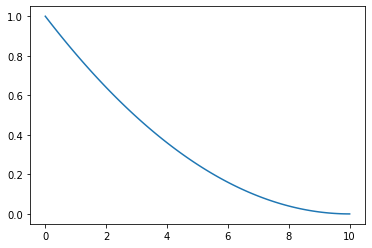

In [49]:
tf=10
nsteps=100
nsteps_b=100
bs=np.linspace(-1,1,nsteps_b)
energy_vs_b=np.zeros(nsteps_b)

time=np.linspace(0,tf,nsteps)
for j,b in enumerate(bs):
    psi=psi_configuration
    dt=time[1]-time[0]
    
    h=1-(1+b)*(time/tf)+b*(time/tf)**2
    
    for i,t in enumerate(time):
        time_hamiltonian=h[i]*InitialHamiltonian.hamiltonian+(1-h[i])*TargetHamiltonian.hamiltonian
        psi=expm_multiply(-1j*dt*time_hamiltonian,psi)

    energy_vs_b[j]=np.abs((psi.conjugate().transpose().dot(TargetHamiltonian.hamiltonian.dot(psi))-egs)/egs)
    psi=psi


plt.plot(time,h)
plt.show()

#### Results

7.850569044680873e-05


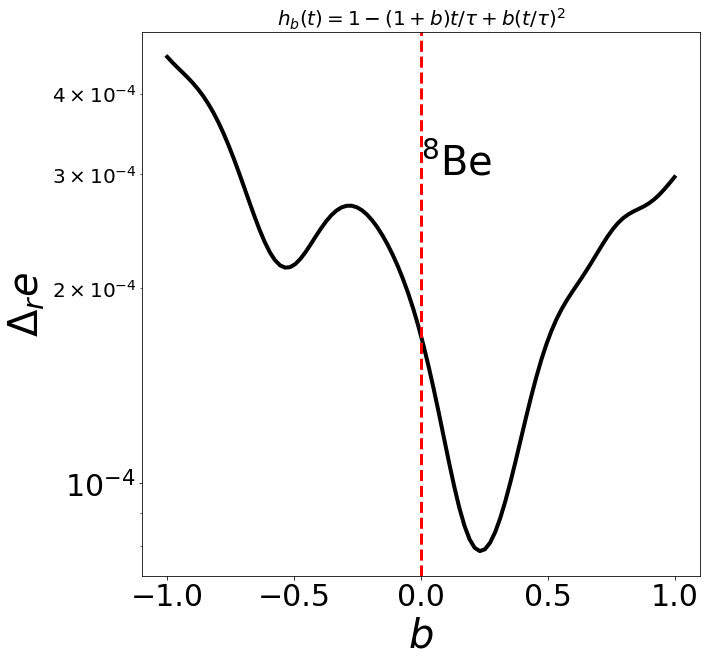

In [41]:
plt.figure(figsize=(10,10))
plt.title(r'$h_b(t)=1-(1+b)t/\tau+b(t/\tau)^2$',fontsize=20)
plt.plot(bs,energy_vs_b,linewidth=4,color='black')
plt.xlabel(r'$b$',fontsize=40)
plt.ylabel(r'$\Delta_r e$',fontsize=40)
print(0.999*np.min(energy_vs_b))
plt.text(s=title,x=0.,y=1-0.9997,fontsize=40)
plt.tick_params(labelsize=30)
plt.tick_params(labelsize=20,which='minor')
plt.axvline(x=0.,linewidth=3,color='red',linestyle='--')
plt.semilogy()
plt.show()

#### Minimum scheduler

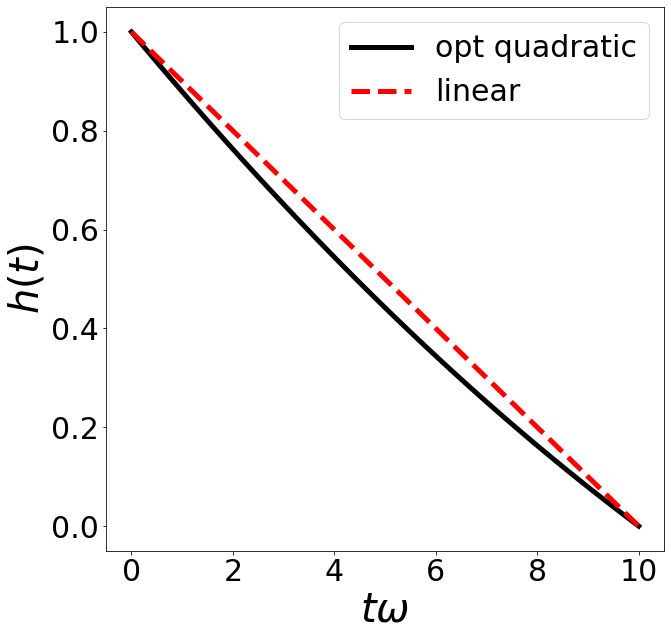

In [53]:
plt.figure(figsize=(10,10))
b_min=np.argmin(energy_vs_b)
h_quadratic=1-(1+bs[b_min])*(time/tf)+bs[b_min]*(time/tf)**2

plt.xlabel(r'$t\omega$',fontsize=40)
plt.ylabel(r'$h(t)$',fontsize=40)
plt.tick_params(labelsize=30)
plt.plot(time,h_quadratic,linewidth=5,color='black',label='opt quadratic')
plt.plot(time,1-time/tf,color='red',linewidth=5,linestyle='--',label='linear')
plt.legend(fontsize=30)
plt.show()



 comments go here

### General optimal control algorithm

#### Imports

In [63]:
from collections import Counter
from src.hamiltonian_utils import FermiHubbardHamiltonian
from src.nuclear_physics_utils import get_twobody_nuclearshell_model,SingleParticleState,QuadrupoleOperator,J2operator,write_j_square_twobody_file
import numpy as np
import torch
from typing import Dict
from src.qml_models import AdaptVQEFermiHubbard
from src.qml_utils.train import Fit
from src.qml_utils.utils import configuration
from scipy.sparse.linalg import eigsh,expm_multiply
from tqdm import trange
import matplotlib.pyplot as plt
import scipy
from typing import List,Type,Optional
from scipy.optimize import minimize
from tqdm import trange

#### Define the Class schedule with both power law expansion and F-CRAB initialization

comments go here

In [128]:
class Schedule:
    
    def __init__(self,tf:float,type:str,number_of_parameters:int,nsteps:int,seed:Optional[int]=None):
        
        self.tf=tf
        self.type=type
        self.time=np.linspace(0,self.tf,nsteps)
        self.parameters=np.zeros(number_of_parameters)
        if self.type=='F-CRAB':
            self.parameters=np.random.uniform(-1,1,number_of_parameters)
        self.seed=seed
        
    def get_driving(self)-> np.ndarray:
        
        if self.type=='power law':
            matrix=(self.parameters[:,None]*(self.time[None,:]/self.tf)**np.arange(1,self.parameters.shape[0]+1)[:,None])
            h=(1-self.time/self.tf)*(1+np.sum(matrix,axis=0))
        
        if self.type=='F-CRAB':
            #np.random.seed(self.seed)
            dim=self.parameters.shape[0]
            #omegas=np.random.uniform(np.pi/self.tf,(1/8)*np.pi/(self.time[1]-self.time[0]),size=self.parameters.shape[0])
            matrix=(self.parameters[:dim//2,None]*np.sin(self.time[None,:]*self.parameters[dim//2:,None]))
            h=(1-self.time/self.tf)*(1+np.average(matrix,axis=0))
        return h

Plot some samples of the driving

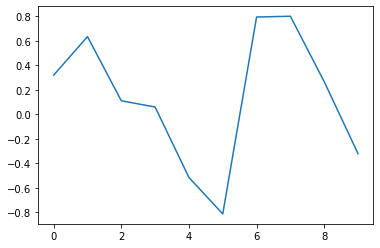

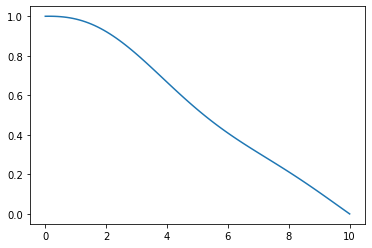

In [129]:
PowerLawScheduler=Schedule(tf=10,type='F-CRAB',number_of_parameters=10,nsteps=100)

PowerLawScheduler.parameters=np.random.uniform(-1,1,size=PowerLawScheduler.parameters.shape[0])
plt.plot(PowerLawScheduler.parameters)
plt.show()
h=PowerLawScheduler.get_driving()

plt.plot(PowerLawScheduler.time,h)
plt.show()

#### Function to optimize (as a class)

In [130]:
class SchedulerModel(Schedule):
    
    def __init__(self,initial_state:np.ndarray,target_hamiltonian: scipy.sparse.spmatrix,initial_hamiltonian: scipy.sparse.spmatrix,tf:float,number_of_parameters:int,nsteps:int,type:str,seed:int):
        
        super().__init__(tf=tf,type=type, number_of_parameters=number_of_parameters,nsteps=nsteps,seed=seed)
        self.target_hamiltonian=target_hamiltonian
        self.initial_hamiltonian=initial_hamiltonian
        self.initial_state=initial_state
        
        
        self.energy=1000
        self.psi=None
    def forward(self,parameters):
        psi=self.initial_state
        dt=self.time[1]-self.time[0]
        self.parameters=parameters
        
        h=self.get_driving()
        
        for i,t in enumerate(self.time):
            time_hamiltonian=h[i]*self.initial_hamiltonian+(1-h[i])*self.target_hamiltonian
            psi=expm_multiply(-1j*dt*time_hamiltonian,psi)

        self.energy=psi.conjugate().transpose().dot(self.target_hamiltonian.dot(psi))
        self.psi=psi
        return self.energy
    
    def callback(self,args):
        
        print(self.energy)
  
        
        

#### Optimization

Initialize the Hamiltonians

In [140]:
file_name:str='data/cki'


j_square_filename:str=file_name+'_j2'
SPS=SingleParticleState(file_name=file_name)
energies:List=SPS.energies


nparticles_a:int=2
nparticles_b:int=2

size_a:int=SPS.energies.shape[0]//2
size_b:int=SPS.energies.shape[0]//2
title=r'$^{8}$Be'


# Target Hamiltonian
TargetHamiltonian=FermiHubbardHamiltonian(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b,symmetries=[SPS.total_M_zero])
if file_name=='data/cki':
    twobody_matrix,energies=get_twobody_nuclearshell_model(file_name=file_name)
    TargetHamiltonian.get_twobody_interaction(twobody_dict=twobody_matrix)
else:
    TargetHamiltonian.twobody_operator=scipy.sparse.load_npz(f'data/nuclear_twobody_matrix/usdb_{nparticles_a}_{nparticles_b}.npz')
print('size=',size_a+size_b,size_b)
TargetHamiltonian.get_external_potential(external_potential=energies[:size_a+size_b])

TargetHamiltonian.get_hamiltonian()

# check the eigenstates
nlevels=5
egs,psis=TargetHamiltonian.get_spectrum(n_states=nlevels)
print('Hamiltonian shape=',TargetHamiltonian.hamiltonian.shape)
egs=egs[0]
print(egs)
psi0=psis[:,:1]



min_b=np.zeros(size_a+size_b)
min_b[0]=1
min_b[3]=1

min_b[0+size_a]=1

min_b[3+size_a]=1




print('initial state=',min_b)
InitialHamiltonian=FermiHubbardHamiltonian(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b,symmetries=[SPS.total_M_zero])
kinetic_term:Dict={}
adj_matrix=np.zeros((size_a+size_b,size_a+size_b))
idx=InitialHamiltonian._get_index(element=min_b)
print('idx=',idx)
psi_configuration=np.zeros(TargetHamiltonian.hamiltonian.shape[0])
psi_configuration[idx]=1
min=psi_configuration.transpose().dot(TargetHamiltonian.hamiltonian.dot(psi_configuration))      
external_field=np.zeros(size_a+size_b)
external_field=-1*(np.abs(min)/(nparticles_a+nparticles_b))*min_b
print('min energy=',min)
InitialHamiltonian.get_external_potential(external_field)
InitialHamiltonian.get_hamiltonian()

nlevels=3

Computing the matrix, pls wait... (u_u) 



  0%|          | 0/12 [00:00<?, ?it/s]

100%|██████████| 12/12 [00:02<00:00,  5.57it/s]
1424it [00:01, 742.69it/s]


size= 12 6
Hamiltonian shape= (51, 51)
-30.295394613605502
initial state= [1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0.]
idx= 5
min energy= -15.405709999999996


In [148]:
model=SchedulerModel(initial_state=psi_configuration,target_hamiltonian=TargetHamiltonian.hamiltonian,initial_hamiltonian=InitialHamiltonian.hamiltonian,tf=20,nsteps=10,number_of_parameters=20,type='F-CRAB',seed=42)


res = minimize(
                    model.forward,
                    model.parameters,
                    method='L-BFGS-B',
                    tol=10**-6,
                    callback=model.callback,
                    options=None,
                    
                )

model.parameters = res.x
energy = model.forward(model.parameters)
print(energy,egs)
print(model.parameters)


/opt/anaconda3/envs/dft_env/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:579: ComplexWarning: Casting complex values to real discards the imaginary part
  J_transposed[i] = df / dx
/opt/anaconda3/envs/dft_env/lib/python3.9/site-packages/scipy/optimize/lbfgsb.py:351: ComplexWarning: Casting complex values to real discards the imaginary part
  _lbfgsb.setulb(m, x, low_bnd, upper_bnd, nbd, f, g, factr,


(-28.308040114464053+0j)
(-28.774661333785374+1.7763568394002505e-15j)
(-28.963974897288946+3.552713678800501e-15j)
(-29.047729958185084+0j)
(-29.14314905034237-1.7763568394002505e-15j)
(-29.25146281185011+0j)
(-29.270565675027658+0j)
(-29.296946259936522-8.881784197001252e-16j)
(-29.321737555854266+1.7763568394002505e-15j)
(-29.361660277889342+0j)
(-29.37852273871246+0j)
(-29.383855185127242+2.220446049250313e-16j)
(-29.384537256292212-8.881784197001252e-16j)
(-29.385735551231576-4.440892098500626e-16j)
(-29.386535540576567+0j)
(-29.388803979141695+0j)
(-29.39196346268482+0j)
(-29.39373959331955+8.881784197001252e-16j)
(-29.39473419070611+3.552713678800501e-15j)
(-29.396028996272406+0j)
(-29.399762519448025-1.7763568394002505e-15j)
(-29.401652422588462-1.7763568394002505e-15j)
(-29.40340181963214+3.552713678800501e-15j)
(-29.40441933382901+3.552713678800501e-15j)
(-29.40611046161242+1.7763568394002505e-15j)
(-29.408101805551595-1.7763568394002505e-15j)
(-29.40942596829022+0j)
(-29.410

0.0035064521709692723


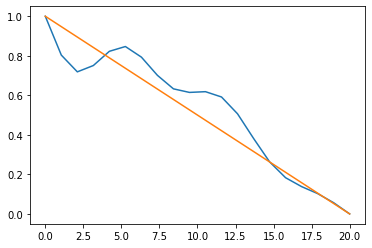

[0.99449125+0.j]


In [146]:
print(np.abs(energy-egs)/np.abs(egs))
plt.plot(model.time,model.get_driving())
plt.plot(model.time,1-model.time/model.tf)
plt.show()
print(model.psi.conjugate()@psi0*(psi0.conjugate().transpose() @ model.psi))

#### Check the performance with the quadratic optimization and the linear one

ValueError: x and y must have same first dimension, but have shapes (20,) and (100,)

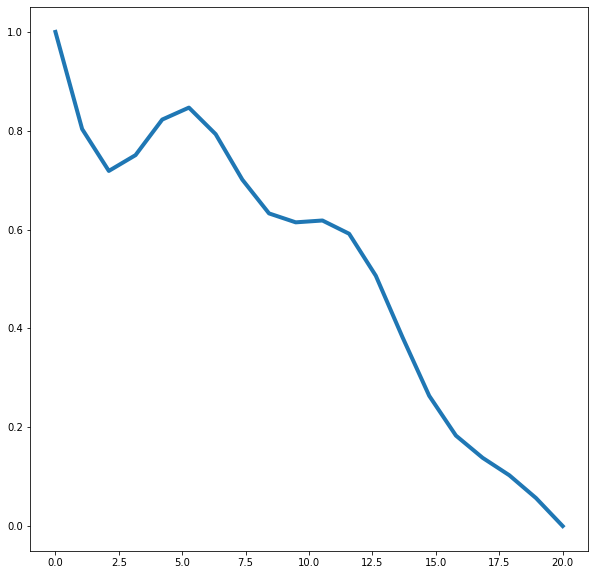

In [147]:

hs=[model.get_driving(),h_quadratic,(1-model.time/model.tf)]
labels=['optimal control','quadratic optimization','linear']
plt.figure(figsize=(10,10))
for i,h in enumerate(hs):
    plt.plot(model.time,h,label=labels[i],linewidth=4)

plt.tick_params(labelsize=30)
plt.xlabel(r'$t \omega$',fontsize=40)
plt.ylabel(r'$h(t)$',fontsize=40)
plt.legend(fontsize=20)
plt.text(s=title,x=0.,y=0.,fontsize=30)
plt.show()
dt=model.time[1]-model.time[0]
energy=[]
fidelity=[]
for j,h in enumerate(hs):
    psi=psi_configuration
    for i,t in enumerate(model.time):
        time_hamiltonian=h[i]*InitialHamiltonian.hamiltonian+(1-h[i])*TargetHamiltonian.hamiltonian
        psi=expm_multiply(-1j*dt*time_hamiltonian,psi)

    energy.append(np.abs((psi.conjugate().transpose().dot(TargetHamiltonian.hamiltonian.dot(psi))-egs)/egs))
    fidelity.append(1-(psi.conjugate()@psi0*(psi0.conjugate().transpose() @ psi)))
    print(fidelity[j])

##### Get the results

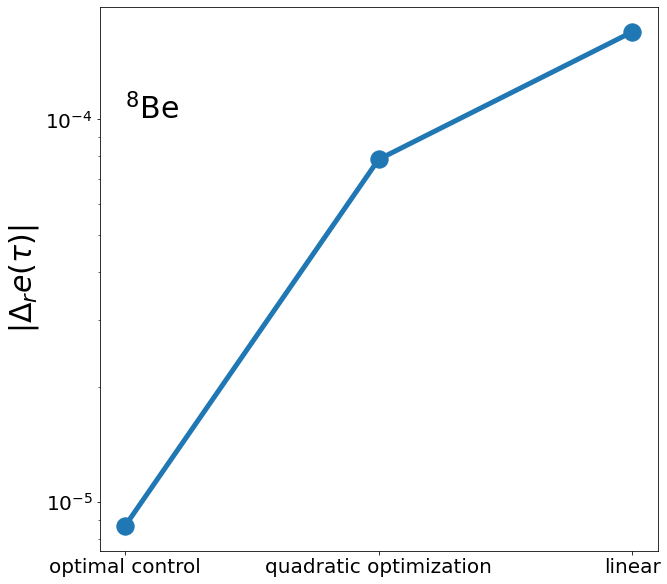

/opt/anaconda3/envs/dft_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/opt/anaconda3/envs/dft_env/lib/python3.9/site-packages/matplotlib/collections.py:200: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


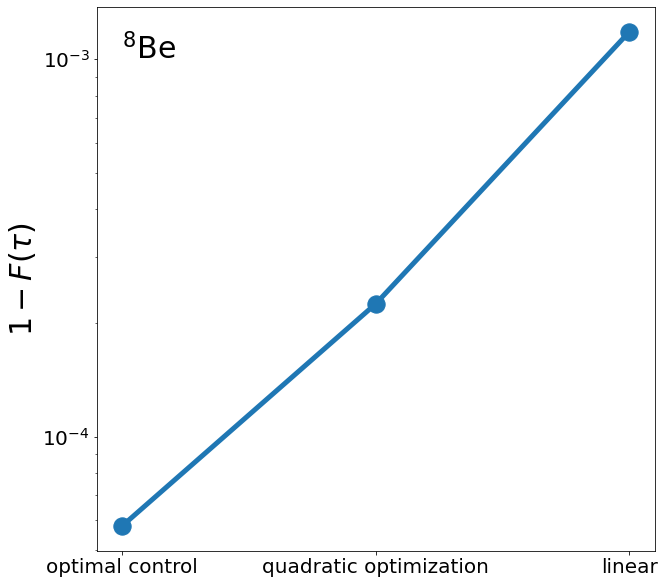

In [135]:
plt.figure(figsize=(10,10))
plt.plot(energy,linewidth=5)
plt.scatter([0,1,2],energy,s=300)
plt.xticks([0,1,2],labels=labels)
plt.tick_params(labelsize=20)
plt.tick_params(labelsize=20,which='minor')
plt.text(s=title,x=0.,y=10**-4,fontsize=30)
plt.semilogy()
plt.ylabel(r'$|\Delta_r e(\tau)|$',fontsize=30)
plt.show()

plt.figure(figsize=(10,10))
plt.plot(fidelity,linewidth=5)
plt.scatter([0,1,2],fidelity,s=300)
plt.xticks([0,1,2],labels=labels)
plt.text(s=title,x=0.,y=10**-3,fontsize=30)
plt.tick_params(labelsize=20)
plt.semilogy()
plt.ylabel(r'$1-F(\tau)$',fontsize=30)
plt.show()

### Test the transfer Learning

In [136]:
file_name:str='data/usdb.nat'


j_square_filename:str=file_name+'_j2'
SPS=SingleParticleState(file_name=file_name)
energies:List=SPS.energies


nparticles_a:int=2
nparticles_b:int=2

size_a:int=SPS.energies.shape[0]//2
size_b:int=SPS.energies.shape[0]//2
title=r'$^{20}$Ne'


# Target Hamiltonian
TargetHamiltonian=FermiHubbardHamiltonian(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b,symmetries=[SPS.total_M_zero])
if file_name=='data/cki':
    twobody_matrix,energies=get_twobody_nuclearshell_model(file_name=file_name)
    TargetHamiltonian.get_twobody_interaction(twobody_dict=twobody_matrix)
else:
    TargetHamiltonian.twobody_operator=scipy.sparse.load_npz(f'data/nuclear_twobody_matrix/usdb_{nparticles_a}_{nparticles_b}.npz')
print('size=',size_a+size_b,size_b)
TargetHamiltonian.get_external_potential(external_potential=energies[:size_a+size_b])

TargetHamiltonian.get_hamiltonian()

# check the eigenstates
nlevels=5
egs,psis=TargetHamiltonian.get_spectrum(n_states=nlevels)
print('Hamiltonian shape=',TargetHamiltonian.hamiltonian.shape)
egs=egs[0]
print(egs)
psi0=psis[:,:1]



min_b=np.zeros(size_a+size_b)
min_b[0]=1
min_b[5]=1

min_b[0+size_a]=1

min_b[5+size_a]=1




print('initial state=',min_b)
InitialHamiltonian=FermiHubbardHamiltonian(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b,symmetries=[SPS.total_M_zero])
kinetic_term:Dict={}
adj_matrix=np.zeros((size_a+size_b,size_a+size_b))
idx=InitialHamiltonian._get_index(element=min_b)
print('idx=',idx)
psi_configuration=np.zeros(TargetHamiltonian.hamiltonian.shape[0])
psi_configuration[idx]=1
min=psi_configuration.transpose().dot(TargetHamiltonian.hamiltonian.dot(psi_configuration))      
external_field=np.zeros(size_a+size_b)
external_field=-1*(np.abs(min)/(nparticles_a+nparticles_b))*min_b
print('min energy=',min)
InitialHamiltonian.get_external_potential(external_field)
InitialHamiltonian.get_hamiltonian()

nlevels=3
nlevels=3

size= 24 12
Hamiltonian shape= (640, 640)
-41.3964900725701
initial state= [1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
idx= 26
min energy= -30.21714603174604


Annealing with the transfer learning for the different drivings

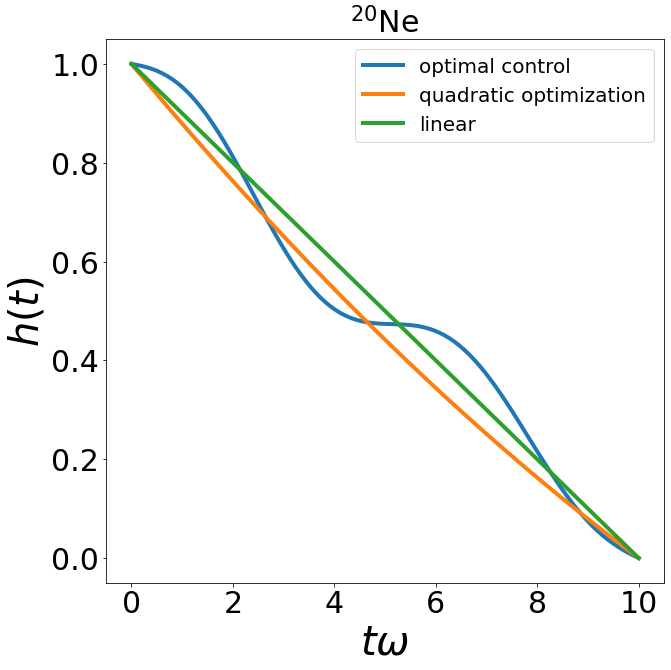

[0.02808391+0.j]
[0.02000017+0.j]
[0.03374443+0.j]


In [137]:
hs=[model.get_driving(),h_quadratic,(1-model.time/model.tf)]
labels=['optimal control','quadratic optimization','linear']
plt.figure(figsize=(10,10))
for i,h in enumerate(hs):
    plt.plot(model.time,h,label=labels[i],linewidth=4)

plt.tick_params(labelsize=30)
plt.xlabel(r'$t \omega$',fontsize=40)
plt.ylabel(r'$h(t)$',fontsize=40)
plt.legend(fontsize=20)
plt.title(title,fontsize=30)
plt.show()
dt=model.time[1]-model.time[0]
energy=[]
fidelity=[]
for j,h in enumerate(hs):
    psi=psi_configuration
    for i,t in enumerate(model.time):
        time_hamiltonian=h[i]*InitialHamiltonian.hamiltonian+(1-h[i])*TargetHamiltonian.hamiltonian
        psi=expm_multiply(-1j*dt*time_hamiltonian,psi)

    energy.append(np.abs((psi.conjugate().transpose().dot(TargetHamiltonian.hamiltonian.dot(psi))-egs)/egs))
    fidelity.append(1-(psi.conjugate()@psi0*(psi0.conjugate().transpose() @ psi)))
    print(fidelity[j])


#### Results

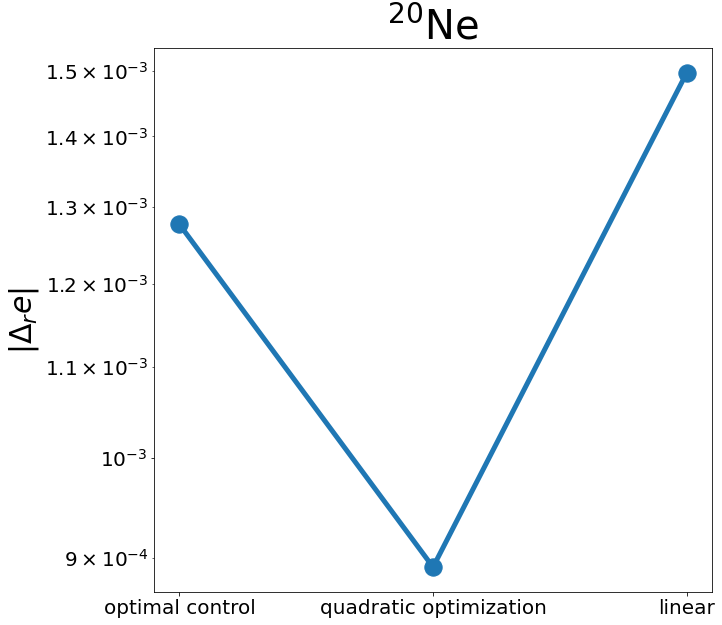

/opt/anaconda3/envs/dft_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/opt/anaconda3/envs/dft_env/lib/python3.9/site-packages/matplotlib/collections.py:200: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


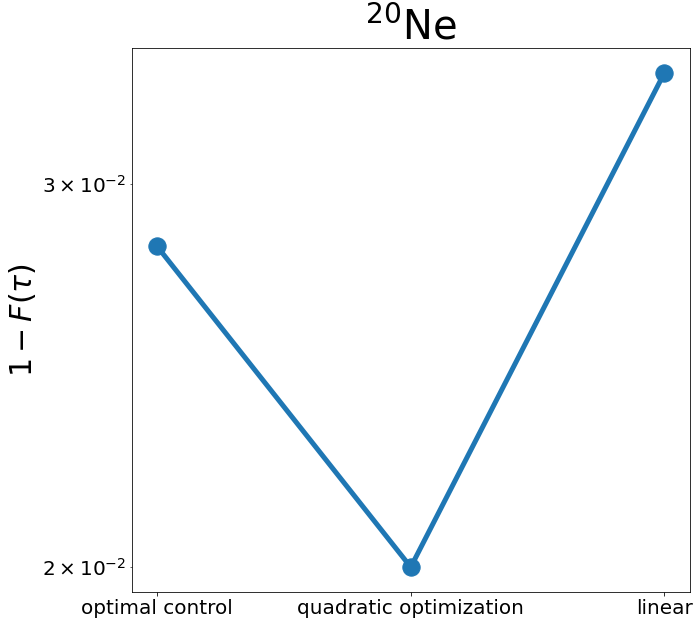

In [138]:
plt.figure(figsize=(10,10))
plt.plot(energy,linewidth=5)
plt.scatter([0,1,2],energy,s=300)
plt.xticks([0,1,2],labels=labels)
plt.tick_params(labelsize=20)
plt.title(title,fontsize=40)
plt.tick_params(labelsize=20,which='minor')
plt.ylabel(r'$|\Delta_r e|$',fontsize=30)
plt.semilogy()
plt.show()

plt.figure(figsize=(10,10))
plt.plot(fidelity,linewidth=5)
plt.scatter([0,1,2],fidelity,s=300)
plt.xticks([0,1,2],labels=labels)
plt.title(title,fontsize=40)
plt.tick_params(labelsize=20)
plt.tick_params(labelsize=20,which='minor')
plt.ylabel(r'$1-F(\tau)$',fontsize=30)

plt.semilogy()
plt.show()